# Fig 7 and Additional figures of "Top-down connection in hierarchical sparse coding" for the CFD database
https://arxiv.org/abs/2002.00892

In [1]:
from SPC_2L.DataTools import DataBase, to_img, show
import pickle
from SPC_2L.Network import LayerPC, Network
from SPC_2L.Coding import ML_FISTA, ML_Lasso
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid, save_image
import torch
from torchvision.transforms import ToTensor,Compose
from SPC_2L.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
from torch.utils.data import DataLoader

## Tools, parameters and database

In [2]:
def to_img(x):
    val_max = x.abs().max(-1, keepdim=True)[0].max(-2, keepdim=True)[0].expand_as(x)
    x += val_max
    x /= 2 * val_max
    x.clamp(0, 1)
    return x

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    return plt


In [4]:
data_path = '../../DataSet/CF_DB_training'

LCN_params = {'kernel_size':11,'sigma':0.5, 'rgb':True} # Local contrast normalization parameters

mask_params={'n': 10} # mask parameters

whitening_params={'f_0':0.5,'n':2} # Whitening parameters

Data_load_param = { 'batch_size': 10,
                    'do_LCN': True,
                    'LCN_params': LCN_params,
                    'do_mask': True,
                    'mask_params': mask_params,
                    'do_whitening': True,
                    'whitening_params': whitening_params,
                    'do_z_score': True,
                    'return_idx': False
                  }

Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124),reshaped_size=(120,171),**Data_load_param, shuffle=True)

nb_image=200

cmap1=plt.get_cmap('tab20c')
cmap2=plt.get_cmap('tab20b')


In [5]:
model_name_list = ['Savings/CFD/'+'CFD_[0.3,1.2]_b=0.pkl', 
                  'Savings/CFD/'+'CFD_[0.3,1.2]_b=1.pkl']

In [6]:
all_sparsity = torch.zeros(nb_image,len(model_name_list),2)
all_activity = torch.zeros(len(model_name_list),2)
all_histo = [None]*len(model_name_list)

for idx_model, model_name in enumerate(model_name_list) : 
    k=0
    with open(model_name, 'rb') as file:
        out = pickle.load(file)
    Net = out['Net']
    Loss = out['Loss']
    Pursuit = out['Pursuit']
    histo = [0,0]

    for idx_batch, data in enumerate(Facedata.data):
        batch = data[0].cuda()
        gamma, it, Loss_G, delta = Pursuit.coding(batch)

        for i in range(Net.nb_layers):
            nb_null = (gamma[i]!=0).float().view(gamma[i].size(0),-1).sum(-1)
            volume = gamma[i].size(1)*gamma[i].size(2)*gamma[i].size(3)
            all_sparsity[k:k+batch.size(0),idx_model,i] = (1-nb_null/volume)*100
            freq = (gamma[i]!=0).view(batch.size(0),gamma[i].size(1),-1)
            freq = freq.sum(-1).sum(0)
            histo[i] += freq 

        print('total Image',k+batch.size(0)) 
        k+=batch.size(0)
        if k >= nb_image:
            break

    all_histo[idx_model] = histo

    Exp = {'model_name': model_name_list,
            'sparsity' : all_sparsity,
            'histo':all_histo}

total Image 10
total Image 20
total Image 30
total Image 40
total Image 50
total Image 60
total Image 70
total Image 80
total Image 90
total Image 100
total Image 110
total Image 120
total Image 130
total Image 140
total Image 150
total Image 160
total Image 170
total Image 180
total Image 190
total Image 200
total Image 10
total Image 20
total Image 30
total Image 40
total Image 50
total Image 60
total Image 70
total Image 80
total Image 90
total Image 100
total Image 110
total Image 120
total Image 130
total Image 140
total Image 150
total Image 160
total Image 170
total Image 180
total Image 190
total Image 200


nb_extrem_low tensor(36, device='cuda:0')
nb_extrem_high tensor(2, device='cuda:0')
torch.Size([16, 3, 9, 9])


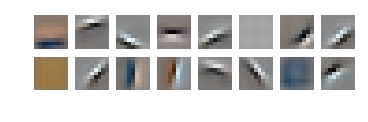

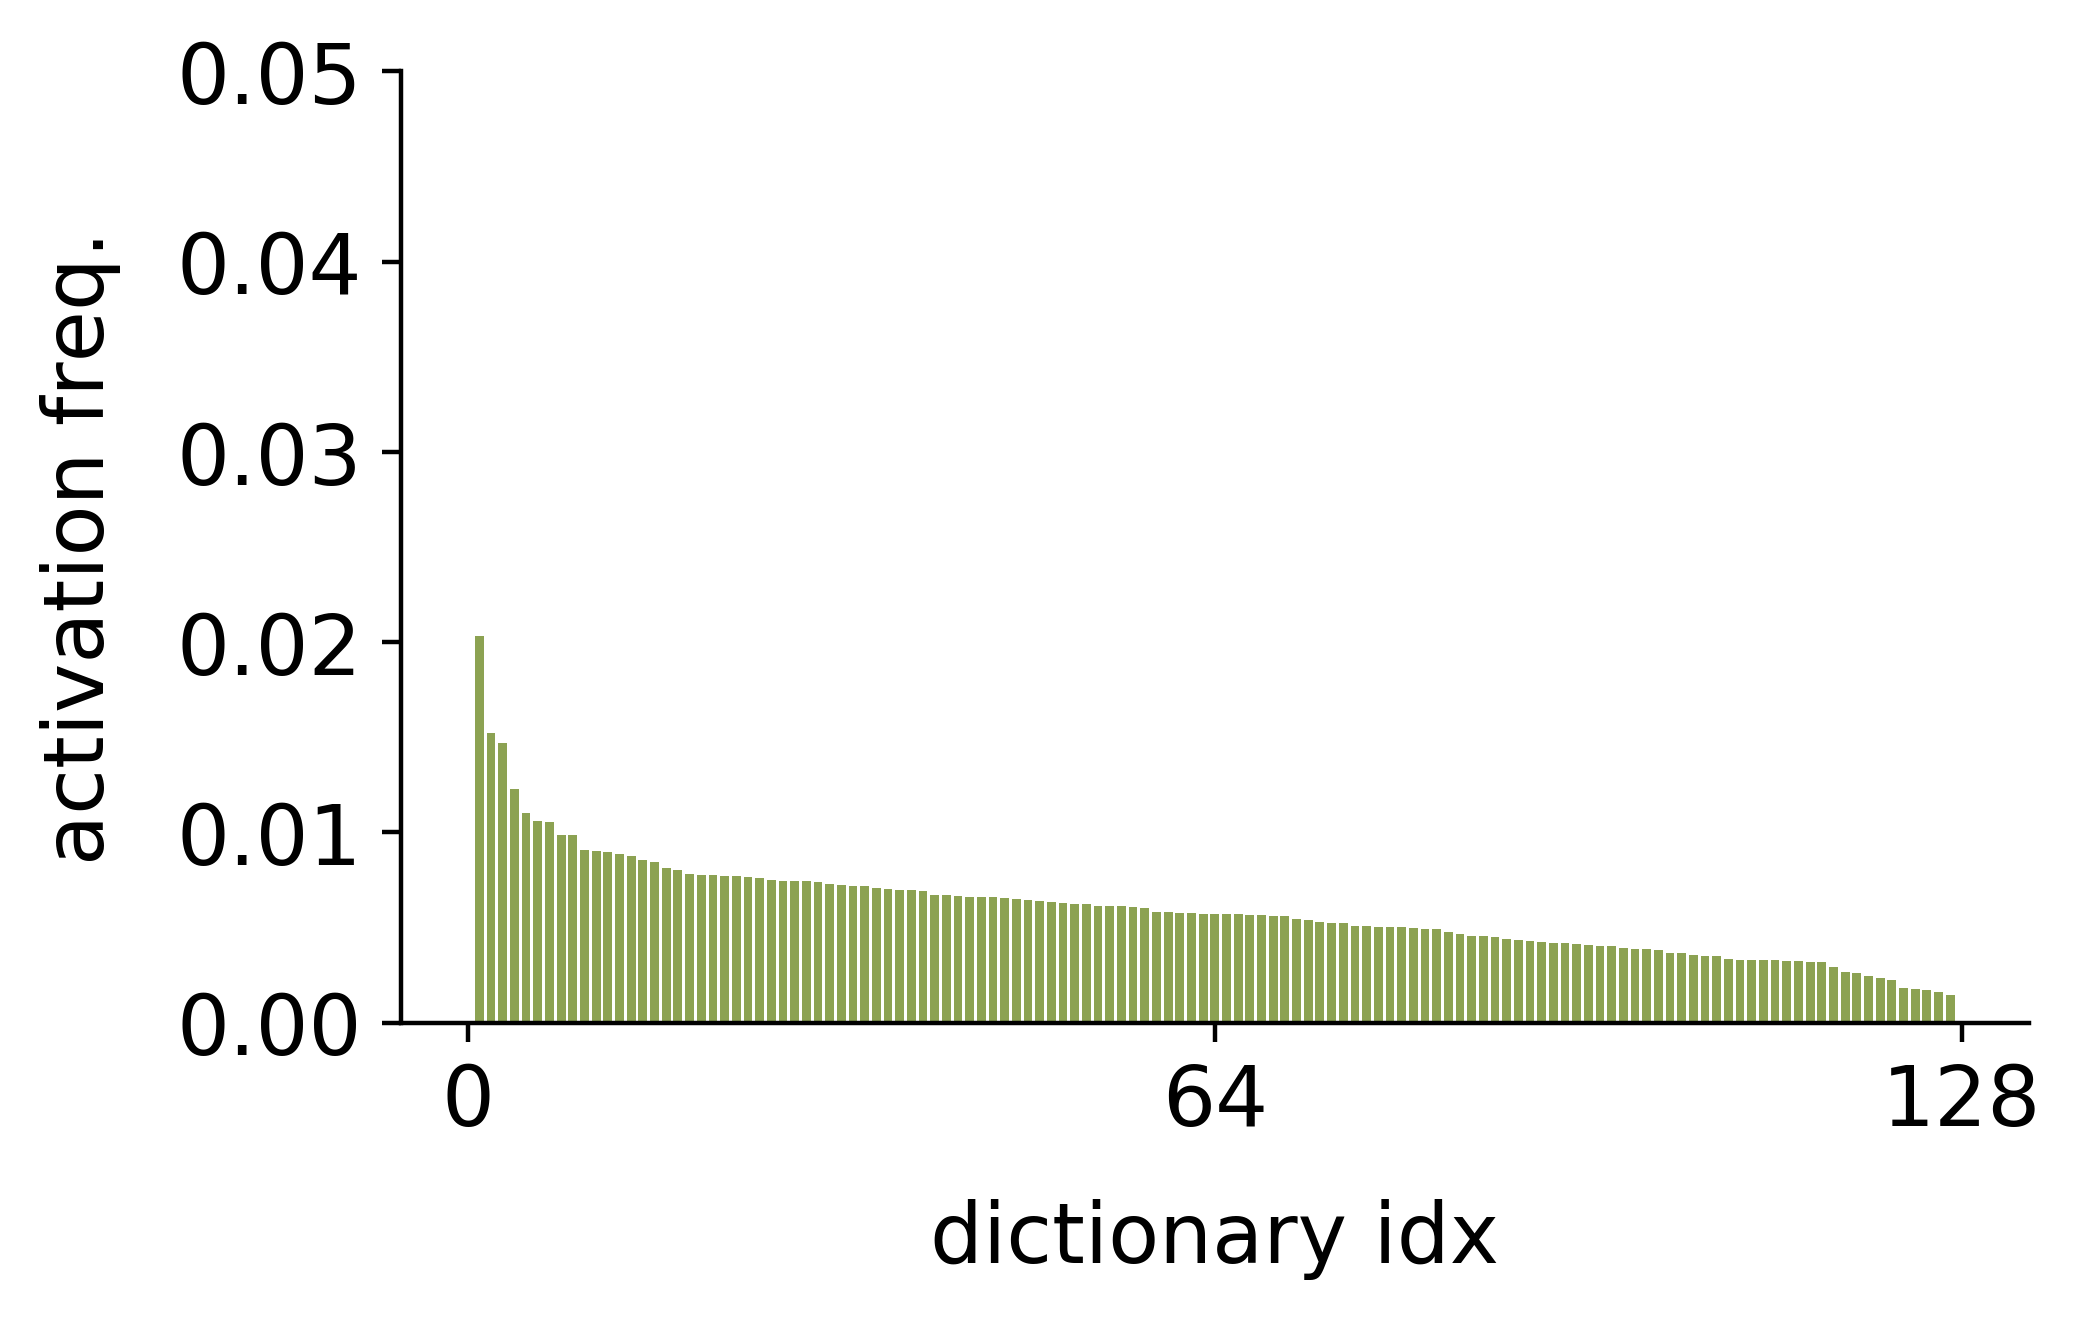

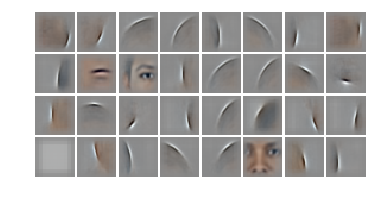

In [7]:
save_fig=False
idx_model = 0
idx_layer=0        
position = torch.arange(all_histo[idx_model][idx_layer].size(0))

inter = Exp['histo'][idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()
sorted_histo, arg_sorted = torch.sort(inter, descending=True)


print('nb_extrem_low',(inter<0.01).sum())
print('nb_extrem_high',(inter>0.05).sum())

## FIST LAYER
grid_param = grid_param = {'padding':2, 'normalize':True, 
                    'pad_value':1, 
                    'nrow':8}
np.random.seed(seed=8)

nb_features = 16
idx_features = np.arange(Net.layers[0].dico.size(0))
np.random.shuffle(idx_features)

img = make_grid(Net.layers[0].dico[idx_features[0:16]],**grid_param)
print(Net.layers[0].dico[idx_features[0:16]].size())

if save_fig == True:
    save_image(img,'Figure_SR2019/Thesis_HiLa_L0_fewfeature.png')

plot_L1 = show(img.cpu())
plot_L1.show()    

idx_layer=1

## SECOND LAYER
position = torch.arange(all_histo[idx_model][idx_layer].size(0))
inter = all_histo[idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()

sorted_histo, arg_sorted = torch.sort(inter, descending=True)

filt = sorted_histo<0.10
width = 0.75 
fig = plt.figure(figsize=(5*1.05,3*1.05),dpi=400)
ax = fig.add_subplot(1,1,1)
barlist = plt.bar(position[filt], sorted_histo[filt].cpu().numpy(), \
                  width, color=cmap2(5))
#mask = arg_sorted == 122
#idx_dico_squared = mask.argmax()

#barlist[idx_dico_squared].set_color('r')
plt.xticks([0,64,128] , fontsize=15)
plt.ylabel('activation freq.', fontsize=15, labelpad=10)
plt.yticks([0.00,0.01,0.02,0.03,0.04,0.05], fontsize=15)
plt.xlabel('dictionary idx', fontsize=15, labelpad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


if save_fig == True:
    plt.tight_layout()
    plt.savefig('Figure_SR2019/CBD_HiLa_Histo_RED',dpi=400)

plt.show()

np.random.seed(seed=2)
nb_features = 64
idx_features = arg_sorted[torch.arange(0,128,4)]
grid_param = grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':8}
effective_dico = Net.project_dico(idx_layer)
img = make_grid(Net.project_dico(1)[idx_features],**grid_param)

plot_L2 = show(img.cpu())

if save_fig == True:
    save_image(img,'Figure_SR2019/CDB_HiLa_L1_fewfeature.png')
    
plot_L2.show()


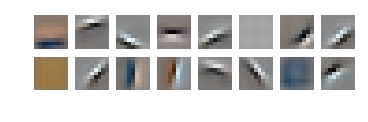

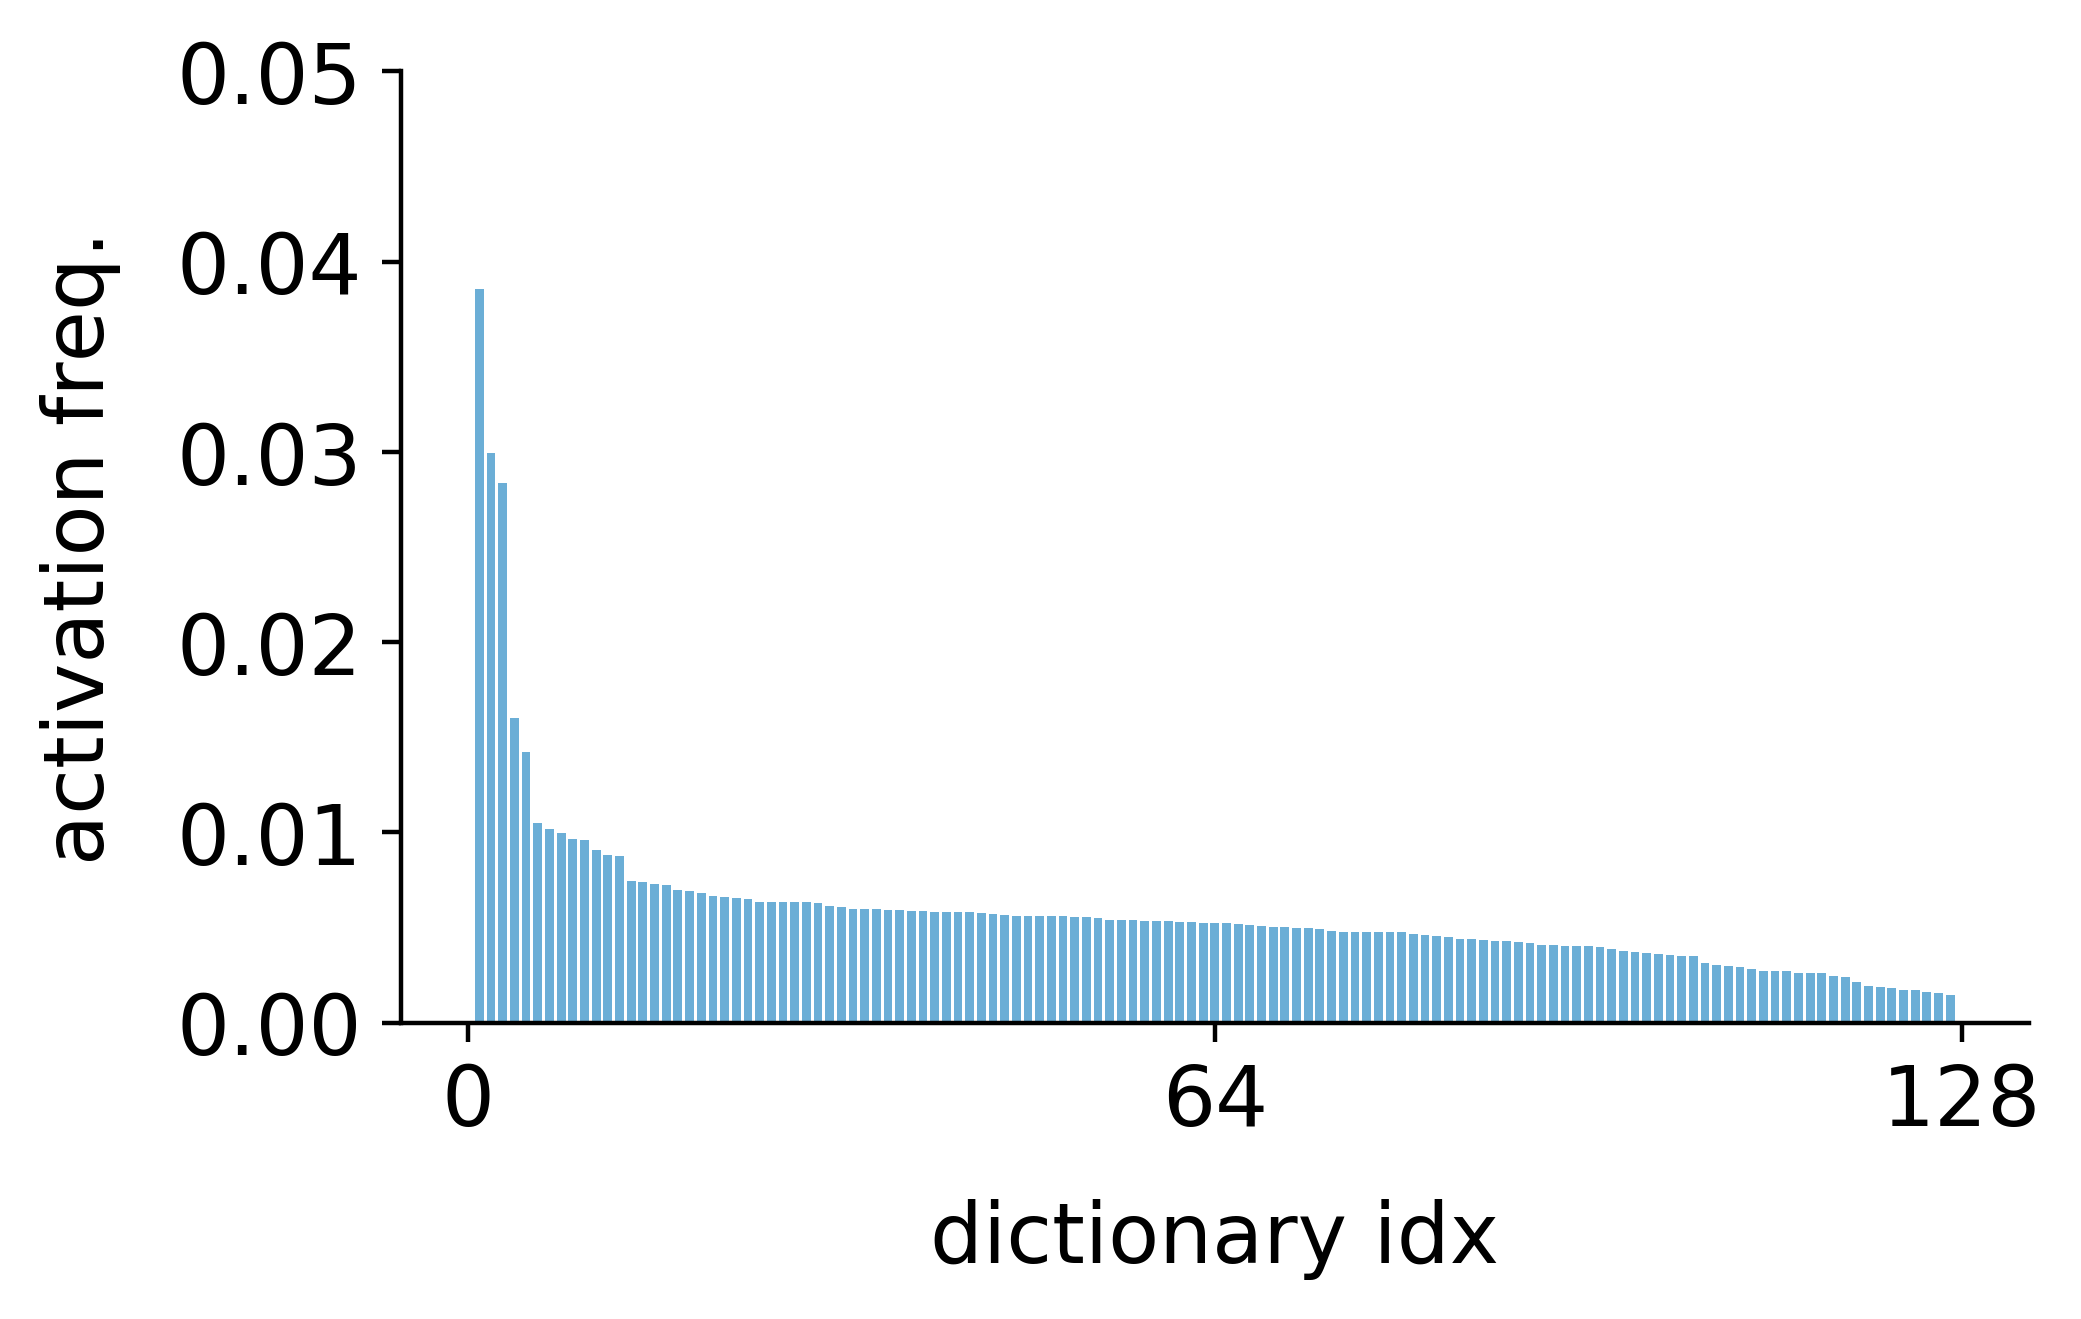

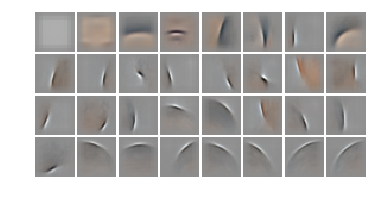

In [8]:
save_fig=False
idx_model = 1
idx_layer=0        
position = torch.arange(all_histo[idx_model][idx_layer].size(0))

inter = Exp['histo'][idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()
sorted_histo, arg_sorted = torch.sort(inter, descending=True)

## FIST LAYER
grid_param = grid_param = {'padding':2, 'normalize':True, 
                    'pad_value':1, 
                    'nrow':8}
np.random.seed(seed=8)

nb_features = 16
idx_features = np.arange(Net.layers[0].dico.size(0))
np.random.shuffle(idx_features)

img = make_grid(Net.layers[0].dico[idx_features[0:16]],**grid_param)

if save_fig == True:
    save_image(img,'Figure_SR2019/Thesis_HiLa_L0_fewfeature.png')

plot_L1 = show(img.cpu())
plot_L1.show()    

idx_layer=1

## SECOND LAYER
position = torch.arange(all_histo[idx_model][idx_layer].size(0))
inter = all_histo[idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()

sorted_histo, arg_sorted = torch.sort(inter, descending=True)

filt = sorted_histo<0.10
width = 0.75 
fig = plt.figure(figsize=(5*1.05,3*1.05),dpi=400)
ax = fig.add_subplot(1,1,1)
barlist = plt.bar(position[filt], sorted_histo[filt].cpu().numpy(), \
                  width, color=cmap1(1))
plt.xticks([0,64,128] , fontsize=15)
plt.ylabel('activation freq.', fontsize=15, labelpad=10)
plt.yticks([0.00,0.01,0.02,0.03,0.04,0.05], fontsize=15)
plt.xlabel('dictionary idx', fontsize=15, labelpad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


if save_fig == True:
    plt.tight_layout()
    plt.savefig('Figure_SR2019/CBD_HiLa_Histo_RED',dpi=400)

plt.show()

np.random.seed(seed=2)
nb_features = 64
idx_features = arg_sorted[torch.arange(0,128,4)]
grid_param = grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':8}
effective_dico = Net.project_dico(idx_layer)
img = make_grid(Net.project_dico(1)[idx_features],**grid_param)

plot_L2 = show(img.cpu())

if save_fig == True:
    save_image(img,'Figure_SR2019/CDB_HiLa_L1_fewfeature.png')
    
plot_L2.show()



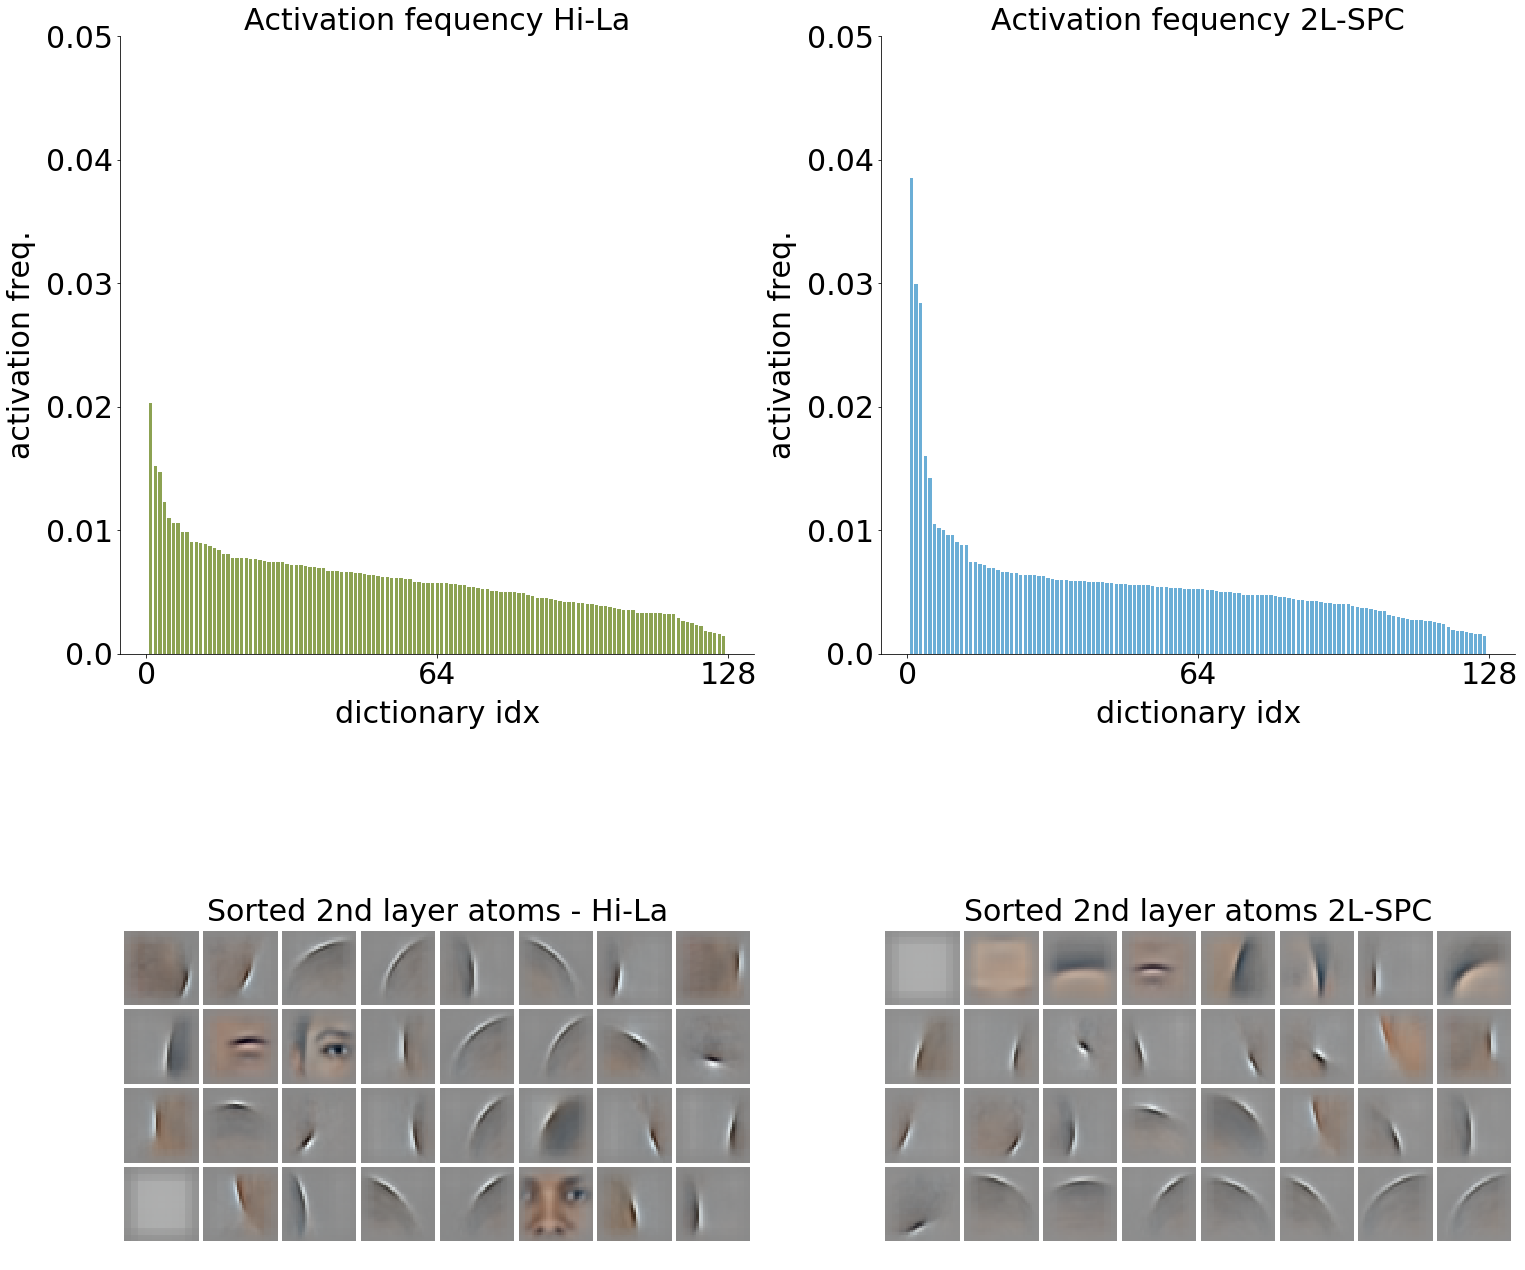

In [28]:
## Generate a nice figure for Github markdown


fig1, ax1 = plt.subplots(nrows=2,ncols=2,figsize=(25,25))
fontsize=30
save_fig=True
idx_model = 0
idx_layer=1        

position = torch.arange(all_histo[idx_model][idx_layer].size(0))

inter = Exp['histo'][idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()
sorted_histo, arg_sorted = torch.sort(inter, descending=True)

filt = sorted_histo<0.10
width = 0.75 
#fig = plt.figure(figsize=(5*1.05,3*1.05),dpi=400)
#ax = fig.add_subplot(1,1,1)
barlist = ax1[0,0].bar(position[filt], sorted_histo[filt].cpu().numpy(), \
                  width, color=cmap2(5))
#mask = arg_sorted == 122
#idx_dico_squared = mask.argmax()

#barlist[idx_dico_squared].set_color('r')
ax1[0,0].set_xticks([0,64,128])
ax1[0,0].set_xticklabels([0,64,128] , fontsize=fontsize)
ax1[0,0].set_ylabel('activation freq.', fontsize=fontsize, labelpad=10)
ax1[0,0].set_yticks([0.00,0.01,0.02,0.03,0.04,0.05])
ax1[0,0].set_yticklabels([0.00,0.01,0.02,0.03,0.04,0.05], fontsize=fontsize)

ax1[0,0].set_xlabel('dictionary idx', fontsize=fontsize, labelpad=10)

ax1[0,0].spines['right'].set_visible(False)
ax1[0,0].spines['top'].set_visible(False)

ax1[0,0].set_title('Activation fequency Hi-La',fontsize=fontsize)




np.random.seed(seed=2)
nb_features = 64
idx_features = arg_sorted[torch.arange(0,128,4)]
grid_param = grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':8}
effective_dico = Net.project_dico(idx_layer)
img = make_grid(Net.project_dico(1)[idx_features],**grid_param)


npimg = img.cpu().numpy()
ax1[1,0].imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
ax1[1,0].set_axis_off()

ax1[1,0].set_title('Sorted 2nd layer atoms - Hi-La',fontsize=fontsize)

## 2L-SPC
idx_model = 1
idx_layer=1        

position = torch.arange(all_histo[idx_model][idx_layer].size(0))

inter = Exp['histo'][idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()
sorted_histo, arg_sorted = torch.sort(inter, descending=True)

filt = sorted_histo<0.10
width = 0.75 
barlist = ax1[0,1].bar(position[filt], sorted_histo[filt].cpu().numpy(), \
                  width, color=cmap1(1))
ax1[0,1].set_xticks([0,64,128])
ax1[0,1].set_xticklabels([0,64,128] , fontsize=fontsize)
ax1[0,1].set_ylabel('activation freq.', fontsize=fontsize, labelpad=10)
ax1[0,1].set_yticks([0.00,0.01,0.02,0.03,0.04,0.05])
ax1[0,1].set_yticklabels([0.00,0.01,0.02,0.03,0.04,0.05], fontsize=fontsize)

ax1[0,1].set_xlabel('dictionary idx', fontsize=fontsize, labelpad=10)

ax1[0,1].spines['right'].set_visible(False)
ax1[0,1].spines['top'].set_visible(False)

ax1[0,1].set_title('Activation fequency 2L-SPC',fontsize=fontsize)




np.random.seed(seed=2)
nb_features = 64
idx_features = arg_sorted[torch.arange(0,128,4)]
grid_param = grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':8}
effective_dico = Net.project_dico(idx_layer)
img = make_grid(Net.project_dico(1)[idx_features],**grid_param)


npimg = img.cpu().numpy()
ax1[1,1].imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
ax1[1,1].set_axis_off()

ax1[1,1].set_title('Sorted 2nd layer atoms 2L-SPC',fontsize=fontsize)



if save_fig == True:
    plt.savefig('Savings/Fig/Fig7.png', bbox_inches = 'tight', pad_inches = 0.1)
    




## Figure 14 a) and c)

In [21]:
model_name_list = ['Savings/CFD/'+'CFD_[0.3,1.2]_b=1.pkl']

In [22]:
all_sparsity = torch.zeros(nb_image,len(model_name_list),2)
all_activity = torch.zeros(len(model_name_list),2)
all_histo = [None]*len(model_name_list)
for idx_model, model_name in enumerate(model_name_list) : 
    k=0
    with open(model_name, 'rb') as file:
        out = pickle.load(file)
    Net = out['Net']
    Loss = out['Loss']
    Pursuit = out['Pursuit']
    histo = [0,0]
    for idx_batch, data in enumerate(Facedata.data):
        batch = data[0].cuda()
        gamma, it, Loss_G, delta = Pursuit.coding(batch)

        for i in range(Net.nb_layers):
            nb_null = (gamma[i]!=0).float().view(gamma[i].size(0),-1).sum(-1)
            volume = gamma[i].size(1)*gamma[i].size(2)*gamma[i].size(3)
            all_sparsity[k:k+batch.size(0),idx_model,i] = (1-nb_null/volume)*100
            freq = (gamma[i]!=0).view(batch.size(0),gamma[i].size(1),-1)
            freq = freq.sum(-1).sum(0)
            histo[i] += freq 
        k+=batch.size(0)
        if k >= nb_image:
            break

    all_histo[idx_model] = histo

Exp = {'model_name': model_name_list,
        'sparsity' : all_sparsity,
        'histo':all_histo}

Dico Layer 1 with feedback


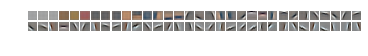

Dico Layer 2 with feedback


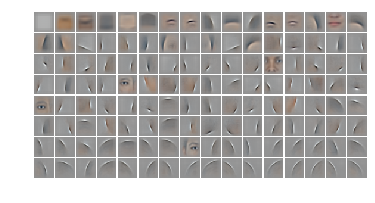

In [23]:
save_fig = True
all_histo = Exp['histo']
with open(model_name_list[0], 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
    
## FIRST LAYER DICTIONARIES
idx_model=0
idx_layer=0
position = torch.arange(all_histo[idx_model][idx_layer].size(0))
inter = all_histo[idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()

fig = plt.figure()
sorted_histo, arg_sorted = torch.sort(inter, descending=True)

grid_param = {'padding':1, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':32}
 
img = make_grid(Net.layers[0].dico[arg_sorted,:,:,:],**grid_param)
plot_L1 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig14/SD_CFD_2LSPC_L1_sorted.pdf')

print('Dico Layer 1 with feedback')
plot_L1.show()
    
## SECOND LAYER DICTIONARIES
idx_layer=1

position = torch.arange(all_histo[idx_model][idx_layer].size(0))
inter = all_histo[idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()

sorted_histo, arg_sorted = torch.sort(inter, descending=True)

fig = plt.figure()

grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':16}
img = make_grid(Net.project_dico(1)[arg_sorted],**grid_param)
plot_L2 = show(img.cpu())

if save_fig == True:
    save_image(img,'Savings/Fig/Fig14/SD_CFD_2LSPC_L2_sorted.pdf')
print('Dico Layer 2 with feedback')
plot_L2.show()

## Figure 14 b) and d)

In [24]:
model_name_list = ['Savings/CFD/'+'CFD_[0.3,1.2]_b=0.pkl']

In [25]:
all_sparsity = torch.zeros(nb_image,len(model_name_list),2)
all_activity = torch.zeros(len(model_name_list),2)
all_histo = [None]*len(model_name_list)
for idx_model, model_name in enumerate(model_name_list) : 
    k=0
    with open(model_name, 'rb') as file:
        out = pickle.load(file)
    Net = out['Net']
    Loss = out['Loss']
    Pursuit = out['Pursuit']
    histo = [0,0]
    for idx_batch, data in enumerate(Facedata.data):
        batch = data[0].cuda()
        gamma, it, Loss_G, delta = Pursuit.coding(batch)

        for i in range(Net.nb_layers):
            nb_null = (gamma[i]!=0).float().view(gamma[i].size(0),-1).sum(-1)
            volume = gamma[i].size(1)*gamma[i].size(2)*gamma[i].size(3)
            all_sparsity[k:k+batch.size(0),idx_model,i] = (1-nb_null/volume)*100
            freq = (gamma[i]!=0).view(batch.size(0),gamma[i].size(1),-1)
            freq = freq.sum(-1).sum(0)
            histo[i] += freq 
        k+=batch.size(0)
        if k >= nb_image:
            break

    all_histo[idx_model] = histo

Exp = {'model_name': model_name_list,
        'sparsity' : all_sparsity,
        'histo':all_histo}

Dico Layer 1 without feedback


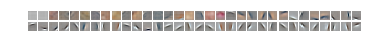

Dico Layer 2 without feedback


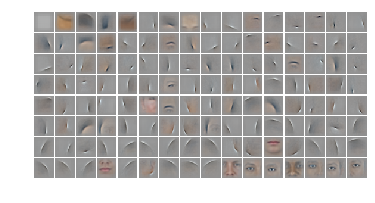

In [26]:
save_fig = True
all_histo = Exp['histo']
with open(model_name_list[0], 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
    
## FIRST LAYER DICTIONARIES
idx_model=0
idx_layer=0
position = torch.arange(all_histo[idx_model][idx_layer].size(0))
inter = all_histo[idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()

fig = plt.figure()
sorted_histo, arg_sorted = torch.sort(inter, descending=True)

grid_param = {'padding':1, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':32}
 
img = make_grid(Net.layers[0].dico[arg_sorted,:,:,:],**grid_param)
plot_L1 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig14/SD_CFD_HiLa_L1_sorted.pdf')

print('Dico Layer 1 without feedback')
plot_L1.show()
    
## SECOND LAYER DICTIONARIES
idx_layer=1

position = torch.arange(all_histo[idx_model][idx_layer].size(0))
inter = all_histo[idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()

sorted_histo, arg_sorted = torch.sort(inter, descending=True)

fig = plt.figure()

grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':16}
img = make_grid(Net.project_dico(1)[arg_sorted],**grid_param)
plot_L2 = show(img.cpu())

if save_fig == True:
    save_image(img,'Savings/Fig/Fig14/SD_CFD_HiLa_L2_sorted.pdf')
print('Dico Layer 2 without feedback')
plot_L2.show()